# **Extracción, limpieza y análisis de datos**

## 1. Introducción

El objetivo del cuaderno es mostrar el funcionamiento de un pipeline para la obtención de subconjuntos de datos a partir de los datasets disponibles en  el catálogo del Banco Mundial https://datacatalog.worldbank.org/home.

### 1.1 Indicadores consultados

1. ODS # 8 Desarrollo Económico Sostenble: _https://datacatalog.worldbank.org/search/dataset/0037918/Sustainable-Development-Goals_ 
 
2. Desarrollo Global: _https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators_
 
3. Governanza*: _https://datacatalog.worldbank.org/search/dataset/0038026/Worldwide-Governance-Indicators_


_*'Selección, monitoreo y reemplazo de gobiernos, la capacidad para formular políticas efectivas y el respeto por las instituciones que rigen las interacciones económicas y sociales.'_

## 2. Importación de librerías:

In [9]:
#Carga de librerías a utilizar en el proceso
import os
import pandas as pd
import wbgapi as wb
import requests
import xml.etree.ElementTree as ET
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import interaction_plot

## 3. **Descarga de datos crudos**

### 3.1 Carga de listas de índices y de países codificados:

Se consultan los directorios definidos para obtener los códigos de los indicadores _('Series Code')_ y los países _('countries') para ser gaurdados en listas._ Se excluyen los indicadores que presentan errores al momento de descargar.

In [10]:
# Carga de índices y lista de paises
# Ruta completa del archivo Excel
ruta_lista_ods = r"C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Fuentes\codigos_indicadores\Sustainable_Development_Goals.xlsx"
ruta_lista_devg = r"C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Fuentes\codigos_indicadores\Codigos_Indicadores_Desarrollo.xlsx"

# Carga el archivo Excel en un DataFrame de pandas
df_ods = pd.read_excel(ruta_lista_ods)
df_devg = pd.read_excel(ruta_lista_devg)

# Ahora 'df' contiene los datos del archivo Excel
list_ods_id = df_ods["Series Code"].dropna().tolist()
list_devg_id = df_devg["Series Code"].dropna().tolist()

# Valores a eliminar
valores_a_eliminar = ["SL.ISV.IFRM.ZS", "SL.ISV.IFRM.FE.ZS", "SL.ISV.IFRM.MA.ZS"]

# Crea una nueva lista excluyendo los valores a eliminar
list_ods_id = [valor for valor in list_ods_id if valor not in valores_a_eliminar]

# Lista de países
countries = ["ARG", "BHS", "BRB", "BOL", "BRA", "CAN", "COL", "CRI", "CUB", "CHL", "ECU", "SLV", "USA", "FRA", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "NLD", "PAN", "PRY", "PER", "GBR", "DOM", "SUR", "TTO", "URY", "VEN"]


#extraer lista de indicadores de corrupción
# URL del documento XML
url = "https://api.worldbank.org/v2/sources/3/indicators"

# Realiza una solicitud HTTP para obtener el contenido del enlace
response = requests.get(url)

# Verifica si la solicitud fue exitosa (código de respuesta 200)
if response.status_code == 200:
    # Parsea el contenido XML
    xml_content = response.content
    root = ET.fromstring(xml_content)

    # Inicializa una lista para almacenar los elementos 'indicator'
    list_corr_id = []

    # Itera a través de los elementos 'indicator' en el árbol XML
    for indicator in root.findall(".//wb:indicator", namespaces={"wb": "http://www.worldbank.org"}):
        # Obtiene el valor del atributo 'id' y el texto dentro del elemento 'wb:name'
        indicator_id = indicator.get("id")
        indicator_name = indicator.find("wb:name", namespaces={"wb": "http://www.worldbank.org"}).text

        # Almacena los datos en un diccionario
        indicator_data = {
            "id": indicator_id,
            "name": indicator_name
        }

        # Agrega el diccionario a la lista de indicadores
        list_corr_id.append(indicator_data)

#len(list_ods_id)

### 3.2 Carga o descarga de datasets en crudo

Se definen los directorios para guardar los datos en crudo. También se define una función para consultar las listas creadas y consultar los indicadores en los países seleccionados para los años registrados. Luego, éstos son transformados a 3 dataframes que consolidan respectivamente los indicadores de los grupos extraídos.

La función **cargar_o_descargar_dataframe** tiene como objetivo gestionar la carga o descarga de DataFrames desde archivos Excel. Fue diseñada para automatizar el proceso de adquisición de datos a partir de indicadores específicos y países, permitiendo la reutilización de datos previamente descargados si el archivo ya existe.

In [11]:
# Ruta donde deseas guardar el archivo Excel para ODS
ruta_guardado_ods = r"C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\raw_data\ods_raw.xlsx"

# Ruta donde deseas guardar el archivo Excel para DEVG
ruta_guardado_devg = r"C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\raw_data\devg_raw.xlsx"

# Ruta donde deseas guardar el archivo Excel para corrupción
ruta_guardado_corr = r"C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\raw_data\corr_raw.xlsx"


# Carga de librerías a utilizar en el proceso
def cargar_o_descargar_dataframe(ruta_guardado, series_codes, countries, archivo_raw):
    if os.path.exists(ruta_guardado):
        # Si el archivo ya existe, carga el DataFrame desde el archivo Excel
        df = pd.read_excel(ruta_guardado)
    else:
        # Si el archivo no existe, crea un diccionario de DataFrames
        dfs = {}

        # Ciclo para crear dataframes para cada indicador
        for series_code in series_codes:
            # Crea un dataframe para el indicador actual
            df = wb.data.DataFrame(
                series_code,
                countries,
                index="time",
                numericTimeKeys=True,
                labels=True
            )

            # Genera un nombre en la notación "id_tipo"
            dataframe_name = f"{series_code}_{archivo_raw}"

            # Agrega el DataFrame al diccionario usando el nombre generado como clave
            dfs[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_dfs = []

        # Recorre el diccionario de DataFrames
        for dataframe_name, df in dfs.items():
            # Agrega una columna 'series_code' con el valor correspondiente
            df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
            # Agrega el DataFrame actual a la lista
            concat_dfs.append(df)

        # Concatena todos los DataFrames en uno solo
        df = pd.concat(concat_dfs, ignore_index=True)

        # Mueve la columna 'series_code' al primer lugar
        df.insert(0, 'series_code', df.pop('series_code'))

        # Guarda el DataFrame como un archivo Excel en la ubicación especificada
        df.to_excel(ruta_guardado, index=False)

    return df

# Cargar o descargar DataFrames
ods_raw_df = cargar_o_descargar_dataframe(ruta_guardado_ods, list_ods_id, countries, "ODS")
devg_raw_df = cargar_o_descargar_dataframe(ruta_guardado_devg, list_devg_id, countries, "DEVG")
corr_raw_df = cargar_o_descargar_dataframe(ruta_guardado_corr, list_corr_id, countries, "CORR")


## 4. Transformación de datos

El proceso de transformación de datos incluye la limpieza, imputación, consolidación y normalización de datos 

### Limpieza e imputación de datos

En primer lugar, se realiza la limpieza de los DataFrames, eliminando las filas (años) que contienen todos sus valores NaN. También, se excluyen las columnas (paises), series (indicadores) y años con un porcentaje de valores perdidos superior al 26%. Esto asegura que los conjuntos de datos resultantes estén libres de valores NaN significativos y sean más adecuados para el análisis.

En la segunda parte, se imputan los valores faltantes (NaN) calculando la mediana por columna en subconjuntos de indicadores. Así, si un país tiene datos perdidos para un indicador en determinados años (menos del 26% de sus datos totales), esos valores se reemplazan por la mediana del país en ese indicador específico.

In [12]:
# Lista para almacenar los nuevos DataFrames sin filas de NaN
clnd_dfs = []

raw_dfs = [ods_raw_df, devg_raw_df, corr_raw_df]

for df in raw_dfs:
    # Copia el DataFrame original para mantenerlo intacto
    nuevo_df = df.copy()
    
    # Guarda las filas eliminadas en otro DataFrame
    filas_eliminadas = nuevo_df[nuevo_df.iloc[:, 2:34].isnull().all(axis=1)]
    
    ## Elimina las filas con todos los valores NaN
    nuevo_df.dropna(subset=nuevo_df.columns[2:34], how='all', inplace=True)
    
    # Agrega el nuevo DataFrame a la lista de nuevos DataFrames
    clnd_dfs.append(nuevo_df)
    
#######paises
## Diccionario para almacenar los resultados
nan_info_dict = {}

# Itera a través de la lista de DataFrames sin filas de NaN (clnd_dfs)
for i, df in enumerate(clnd_dfs):
    # Calcula la cantidad de datos NaN por cada columna en el DataFrame
    nan_count_per_column = df.isna().sum()
    
    # Calcula el porcentaje de datos perdidos en cada columna
    total_rows = len(df)
    nan_percentage_per_column = (nan_count_per_column / total_rows) * 100
    
    # Almacena la información en un DataFrame
    nan_info_df = pd.DataFrame({
        "NaN_Count": nan_count_per_column,
        "NaN_Percentage": nan_percentage_per_column
    })
    
    # Ordena el DataFrame por la columna "NaN_Count" en orden descendente
    nan_info_df = nan_info_df.sort_values(by="NaN_Count", ascending=False)
    
    # Agrega el DataFrame con la información al diccionario
    nan_info_dict[f"clean_{i + 1}"] = nan_info_df

# Obtener el DataFrame correspondiente a clean_ods_df en nan_info_dict (por índice)
nan_info_clean_ods = list(nan_info_dict.values())[0]

#### Filtrar las columnas con porcentaje superior al 26.0
columns_to_exclude = nan_info_clean_ods[nan_info_clean_ods["NaN_Percentage"] > 26.0].index.tolist()

# Eliminar las columnas coincidentes de los dos primeros DataFrames en clnd_dfs
for i in range(2):
    clnd_dfs[i] = clnd_dfs[i].drop(columns=columns_to_exclude)

# Crear el nuevo DataFrame excluded_corr a partir de clnd_dfs[2]
excluded_corr = clnd_dfs[2][columns_to_exclude]

# Eliminar las columnas coincidentes de clnd_dfs[2]
clnd_dfs[2] = clnd_dfs[2].drop(columns=columns_to_exclude)

# Almacenar los DataFrames en sus variables originales (opcional)
clnd_dfs.append(excluded_corr)

##########indicadores

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "series_code"
    unique_series_codes = df["series_code"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_series = {}

    # Filtra el DataFrame por cada valor único en "series_code" y calcula el porcentaje de NaN
    for series_code in unique_series_codes:
        filtered_df = df[df["series_code"] == series_code]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_series[series_code] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_series

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs

# Crear listas de series_code que tengan un porcentaje superior a 26.0 en los tres primeros DataFrames de clnd_dfs
series_codes_to_exclude = set()

# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    for series_code, nan_percentage in nan_percentage_dict[f"clean_{i + 1}"].items():
        if nan_percentage > 26.0:
            series_codes_to_exclude.add(series_code)

# Filtrar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["series_code"].isin(series_codes_to_exclude)]

# Ahora clnd_dfs contiene los DataFrames sin las filas con series_code con porcentaje superior a 26.0 en los tres primeros DataFrames



#######años

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "Year"
    unique_years = df["Time"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_year = {}

    # Filtra el DataFrame por cada valor único en "Year" y calcula el porcentaje de NaN
    for year in unique_years:
        filtered_df = df[df["Time"] == year]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_year[year] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_year

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs


# Crear una lista para almacenar los años con porcentaje superior a 26.0
years_to_exclude = []

# Iterar a través del nan_percentage_dict
for i in range(3):
    nan_percentage_per_year = nan_percentage_dict[f"clean_{i + 1}"]
    for year, nan_percentage in nan_percentage_per_year.items():
        if nan_percentage > 26.0 and year not in years_to_exclude:
            years_to_exclude.append(year)

# Eliminar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["Time"].isin(years_to_exclude)]
    
# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    df = clnd_dfs[i]  # Obtén el DataFrame actual
    unique_series_codes = df["series_code"].unique()  # Obtiene los valores únicos en "series_code"

    # Iterar a través de los valores únicos en "series_code"
    for series_code in unique_series_codes:
        # Filtra el DataFrame por el valor único en "series_code" y copia el resultado
        filtered_df = df[df["series_code"] == series_code].copy()
        
        # Calcula la mediana por columna en el subconjunto de datos y reemplaza NaN por la mediana
        median_values = filtered_df.median(numeric_only=True)  # Calcula la mediana por columna
        filtered_df.fillna(median_values, inplace=True)  # Reemplaza NaN por la mediana en el DataFrame copiado

        # Actualiza el DataFrame original con los valores reemplazados
        df.update(filtered_df)



### Consolidación y normalización de datos

En esta etapa, se realiza una preparación de los DataFrames, inicialmente transponiéndolos para representar registros de países en años específicos para cada indicador. Además, se excluyen los datos de años en los cuales no hay registros en los indicadores de corrupción, igualando así los datos disponibles en las variables objetivo (desarrollo sostenible y desarrollo global) para todos los indicadores en términos de años y países según las variables independientes (corrupción).

Posteriormente, se ordenan los datos en tres DataFrames distintos: result_df1 (corrupción), result_df2 (desarrollo sostenible), y result_df3 (desarrollo global). Adicionalmente, se establecen manualmente determinados a indicadores a excluir debido al poco valor de análisis que representan para los objetivos del estudio. 

A continuación, se consolida la información en un mismo DataFrame aplicando una función para ordenar cada DataFrame por el país en orden alfabético y el año en orden descendente. Luego, a los nombre de columna de los indicadores, se les asignan prefijos distintos ("CRP_", "ODS_", "GDE_") para reconocer a qué grupo de indicadores corresponde cada columna. También, se concatenan estas columnas normalizadas en un único DataFrame llamado merged_df 

Por último, la normalización se efectúa mediante el Escalamiento Min-Max, garantizando que los valores de las columnas estén en un rango uniforme para facilitar el análisis comparativo de los datos. 

In [13]:
# Ahora, clnd_dfs contiene los DataFrames originales con los valores NaN reemplazados por las medianas correspondientes en cada serie_code

###Consolidación
#guardar dataframes consolidado de indicadores
clean_ods_df = clnd_dfs[0]  # Primer DataFrame en la lista
clean_devg_df = clnd_dfs[1]  # Segundo DataFrame en la lista
clean_corr_df = clnd_dfs[2]  # Tercer DataFrame en la lista


### Filtro para igualación de datos
def create_filtered_dataframes(original_df):
    # Obtiene los valores únicos de la columna 'series_code'
    unique_series_codes = original_df['series_code'].unique()

    # Diccionario para almacenar los nuevos DataFrames
    new_dfs = {}

    for series_code in unique_series_codes:
        
        original_df['Time'] = original_df['Time'].astype(int)
        
        
        # Filtra el DataFrame original por 'series_code'
        filtered_df = original_df[original_df['series_code'] == series_code]
        
        
        # Obtén los nombres de las columnas en lugar de los valores de la columna "Time"
        nombres_columnas = list(filtered_df.columns[2:])
        
        # Crear un DataFrame para almacenar datos
        transposed_df = pd.DataFrame()
        
        for country in nombres_columnas:
            
            slide_df = pd.DataFrame()
            slide_df["Year"] = filtered_df['Time']
            slide_df[series_code] = filtered_df[country]
            slide_df["Country"] = country

            # Reorganizar las columnas
            slide_df = slide_df[['Country', 'Year', series_code]]

            # Utiliza el método concat para agregar slide_df a transposed_df
            transposed_df = pd.concat([transposed_df, slide_df], ignore_index=True)
                                      
        # Almacena el DataFrame transpuesto en el diccionario new_dfs
        new_dfs[series_code] = transposed_df

    return new_dfs

dataframe_dict1 = create_filtered_dataframes(clean_corr_df)
dataframe_dict2 = create_filtered_dataframes(clean_ods_df)
dataframe_dict3 = create_filtered_dataframes(clean_devg_df)


###Selección de indicadores relevantes

# Función para unir DataFrames y devolver el DataFrame resultante
def merge_dataframes(dataframe_dict):
    # Inicializa el DataFrame resultante con las primeras 2 columnas
    result_df = pd.DataFrame({'Country': [], 'Year': []})
    
    # Realiza una unión externa (outer join) de todos los DataFrames en el diccionario
    for series_code, df in dataframe_dict.items():
        result_df = pd.merge(result_df, df, on=['Country', 'Year'], how='outer')
    
    # Reordena las columnas para tener 'Country' y 'Year' al principio
    result_columns = ['Country', 'Year'] + [col for col in result_df.columns if col not in ['Country', 'Year']]
    result_df = result_df[result_columns]
    
    # Devuelve el DataFrame resultante
    return result_df

# Llama a la función para unir DataFrames y obtener el resultado
result_df1 = merge_dataframes(dataframe_dict1)
result_df2 = merge_dataframes(dataframe_dict2)
result_df3 = merge_dataframes(dataframe_dict3)



####
# Obtener la lista de valores únicos en la columna 'Year' de result_df1
unique_years = result_df1['Year'].unique()

# Filtrar result_df2 y result_df3 para que solo contengan los valores coincidentes en la columna 'Year'
result_df2 = result_df2[result_df2['Year'].isin(unique_years)]
result_df3 = result_df3[result_df3['Year'].isin(unique_years)]
# Elimina las columnas desde la posición 3 hasta 12 (índice 3 al 12) en result_df2
result_df2 = result_df2.drop(result_df2.columns[2:11], axis=1)

####
columns_to_remove_corr = [
    'CC.NO.SRC', 'CC.PER.RNK.LOWER', 'CC.PER.RNK.UPPER', 'CC.STD.ERR', 'CC.PER.RNK',
    'GE.NO.SRC', 'GE.PER.RNK.LOWER', 'GE.PER.RNK.UPPER', 'GE.STD.ERR', 'GE.PER.RNK',
    'PV.NO.SRC', 'PV.PER.RNK.LOWER', 'PV.PER.RNK.UPPER', 'PV.STD.ERR', 'PV.PER.RNK',
    'RQ.NO.SRC', 'RQ.PER.RNK.LOWER', 'RQ.PER.RNK.UPPER', 'RQ.STD.ERR', 'RL.PER.RNK',
    'RL.NO.SRC', 'RL.PER.RNK.LOWER', 'RL.PER.RNK.UPPER', 'RL.STD.ERR', 'RQ.PER.RNK',
    'VA.NO.SRC', 'VA.PER.RNK.LOWER', 'VA.PER.RNK.UPPER', 'VA.STD.ERR', 'VA.PER.RNK'
]

result_df1 = result_df1.drop(columns=columns_to_remove_corr)



columns_to_remove_ods = [
    'FB.CBK.BRCH.P5', 'SL.GDP.PCAP.EM.KD'
]

result_df2 = result_df2.drop(columns=columns_to_remove_ods)

columns_to_remove_devg = [
    'BX.KLT.DINV.WD.GD.ZS', 'BM.KLT.DINV.WD.GD.ZS', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.KD', 'NY.GDP.PCAP.CD',
    'SL.UEM.TOTL.ZS', 'SL.UEM.1524.ZS'
]

result_df3 = result_df3.drop(columns=columns_to_remove_devg)

####
# Función para reemplazar NaN por la mediana de cada columna dentro de cada grupo 'Country'
def replace_nan_with_column_median(df):
    return df.fillna(df.median(numeric_only=True))

# Función para procesar un DataFrame
def process_dataframe(df):
    # Filtrar por cada elemento de la columna 'Country' y reemplazar los NaN por la mediana de cada columna
    df = df.groupby('Country').apply(replace_nan_with_column_median)
    
    # Reemplazar los valores faltantes restantes con cero en todo el DataFrame
    df.fillna(0, inplace=True)
    
    # Reiniciar los índices después del groupby
    df = df.reset_index(drop=True)
    
    return df

# Supongamos que result_df2 y result_df3 son tus DataFrames con NaN
result_df2 = process_dataframe(result_df2)
result_df3 = process_dataframe(result_df3)

####Ordenamiento y consolidación de datos
# Función para ordenar un DataFrame por 'Country' en orden alfabético y 'Year' en orden descendente
def sort_dataframe(df):
    return df.sort_values(by=['Country', 'Year'], ascending=[True, False])

# Supongamos que result_df1, result_df2 y result_df3 son tus DataFrames

result_df1 = sort_dataframe(result_df1)
result_df2 = sort_dataframe(result_df2)
result_df3 = sort_dataframe(result_df3)

main_subset = result_df1.iloc[:, :2]

# Extraer solo las dos primeras columnas de result_df2
result_df1_subset = result_df1.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df2
result_df2_subset = result_df2.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df3
result_df3_subset = result_df3.iloc[:, 2:]

# Agregar prefijo a las columnas de result_df1
result_df1_subset = result_df1_subset.add_prefix("CRP_")

# Agregar prefijo a las columnas de result_df2
result_df2_subset = result_df2_subset.add_prefix("ODS_")

# Agregar prefijo a las columnas de result_df3
result_df3_subset = result_df3_subset.add_prefix("GDE_")


# Concatenar las dos primeras columnas de los tres DataFrames en uno solo
merged_df = pd.concat([main_subset,result_df1_subset, result_df2_subset, result_df3_subset], axis=1)

# Lista de nombres de las columnas desde la tercera columna en adelante
columnas_a_normalizar = merged_df.columns[2:]

# Realizar el Escalamiento Min-Max
for columna in columnas_a_normalizar:
    min_valor = merged_df[columna].min()
    max_valor = merged_df[columna].max()
    merged_df[columna] = (merged_df[columna] - min_valor) / (max_valor - min_valor)

# Ruta donde se guardará o cargará el archivo Excel
ruta_guardado_merged = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\structured_data\merged_df_normalized.xlsx'

# Verificar si el archivo ya existe
if os.path.exists(ruta_guardado_merged):
    # Si existe, cargar el DataFrame desde el archivo Excel
    merged_df = pd.read_excel(ruta_guardado_merged)
else:
    # Si no existe, realizar la normalización y luego guardar el DataFrame en un archivo Excel
    # ... (código anterior para normalización)
    merged_df.to_excel(ruta_guardado_merged, index=False)


## 5. Análisis estadístico y modelado

### 5.1. Matriz de correlación

En esta fase del proceso, se inicia eliminando la columna 'Country' de merged_df, obteniendo así merged_df1, facilitando el análisis mediante matriz de correlación. 

A continuación, se genera una matriz de correlación para evaluar las relaciones entre las variables restantes. Se filtran las correlaciones que superan el umbral de 0.75, eliminando aquellas que están completamente relacionadas (correlación igual a 1). Los resultados relevantes en la matriz de correlación se guardan un el DataFrame.

Posteriormente, se obtienen los elementos únicos en los índices y nombres de columnas para crear un nuevo DataFrame llamado reduced_df. Este último DataFrame incluye las columnas 'Country' y 'Year', así como las variables de corrupción con correlaciones significativas.

Con el objetivo de validar la observación de las tendencias en el DataFrame que abarca todos los países a la situación específica de Colombia, se creó una segunda matriz de correlación. En este caso, se seleccionaron únicamente los indicadores más relevantes identificados en la primera matriz de correlación, comprobando así si las correlaciones relevantes identificadas en el DataFrame de todos los países se presentan en el subconjunto de datos de indicadores de Colombia.

In [14]:
# Elimina la columna 'Country' de merged_df
merged_df1 = merged_df.drop(columns=['Country'])

# Genera la matriz de correlación
correlaciones = merged_df1.corr()

# Filtra las correlaciones mayores a 0.75
correlaciones_altas = correlaciones[(correlaciones > 0.75) & (correlaciones < 1.0)]

# Retira las filas correspondientes a las columnas de interés
filas_de_interes = [columna for columna in merged_df.columns if columna.startswith('CRP_')]

correlaciones_altas = correlaciones_altas.drop(index=filas_de_interes)

# Retira las columnas que no están en la lista de filas_de_interes
correlaciones_altas = correlaciones_altas[filas_de_interes]

# Elimina las filas que tengan datos perdidos en todas las columnas
correlaciones_altas = correlaciones_altas.dropna(how='all')

# Obtener elementos únicos en los índices y nombres de columnas
elementos_unicos = list(set(correlaciones_altas.index) | set(correlaciones_altas.columns))

reduced_df = merged_df[['Country', 'Year'] + elementos_unicos]

##Correlación específica para Colombia
merged_df2_1 = merged_df[merged_df['Country'] == 'COL']

merged_df2_2 = merged_df2_1[elementos_unicos]

# Genera la matriz de correlación
correlaciones2 = merged_df2_2.corr()

# Filtra las correlaciones mayores a 0.75
correlaciones_altas2 = correlaciones2[(correlaciones2 > 0.75) & (correlaciones2 < 1.0)]

# Retira las filas correspondientes a las columnas de interés
filas_de_interes2 = [columna2 for columna2 in merged_df2_2.columns if columna2.startswith('CRP_')]

correlaciones_altas2 = correlaciones_altas2.drop(index=filas_de_interes2)

# Retira las columnas que no están en la lista de filas_de_interes
correlaciones_altas2 = correlaciones_altas2[filas_de_interes2]

# Elimina las filas que tengan datos perdidos en todas las columnas
correlaciones_altas2 = correlaciones_altas2.dropna(how='all')

# Obtener elementos únicos en los índices y nombres de columnas
elementos_unicos2 = list(set(correlaciones_altas2.index) | set(correlaciones_altas2.columns))

reduced_df2 = merged_df2_1[['Country', 'Year'] + elementos_unicos2]

# Ruta donde se guardará o cargará el archivo Excel
ruta_guardado_reduced = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\structured_data\reduced_df_normalized.xlsx'

# Verificar si el archivo ya existe
if os.path.exists(ruta_guardado_reduced):
    # Si existe, cargar el DataFrame desde el archivo Excel
    reduced_df_df = pd.read_excel(ruta_guardado_reduced)
else:
    # Si no existe, realizar la normalización y luego guardar el DataFrame en un archivo Excel
    # ... (código anterior para normalización)
    reduced_df.to_excel(ruta_guardado_reduced, index=False)


### 5.2. Comprobación de normalidad

Se lleva a cabo una prueba de normalidad Anderson-Darling para evaluar la distribución de las variables numéricas. El nivel de significancia (alfa) se establece en 0.05. Se crea un DataFrame llamado para almacenar los resultados de esta prueba, incluyendo la variable evaluada, el estadístico de Anderson-Darling, el valor crítico y la conclusión sobre la normalidad. El bucle itera sobre las columnas numéricas, aplicando la prueba de normalidad a cada una. Los resultados muestran si cada variable sigue una distribución normal o no, basándose en la comparación entre el estadístico y el valor crítico.

Igualmente, se realizó la comprobación de normalidad para las variables altamente correlacionadas en el dataframe filtrado con los datos de Colombia.

#### 5.2.1 Dataframe completo

In [15]:
### Normalidad datos globales
# Definir el nivel de significancia (alfa)
alpha = 0.05

# Crear un DataFrame para almacenar los resultados
resultados_normalidad = pd.DataFrame(columns=['Variable', 'Estadístico', 'Valor Crítico', 'Conclusión'])

# Obtener las columnas numéricas (excluyendo 'Country' y 'Year')
columnas_numericas = [col for col in reduced_df.columns if col not in ['Country', 'Year']]

for columna in columnas_numericas:
    result = stats.anderson(reduced_df[columna], dist='norm')
    statistic = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level
    conclusion = "Normal" if statistic < critical_values[2] else "No Normal"
    
    nueva_fila = {
        'Variable': columna,
        'Estadístico': statistic,
        'Valor Crítico': critical_values[2],
        'Conclusión': conclusion
    }
    
    resultados_normalidad = pd.concat([resultados_normalidad, pd.DataFrame([nueva_fila])], ignore_index=True)    

###Normalidad datos Colombia    
# Definir el nivel de significancia (alfa)
alpha = 0.05

# Crear un DataFrame para almacenar los resultados
resultados_normalidad2 = pd.DataFrame(columns=['Variable', 'Estadístico', 'Valor Crítico', 'Conclusión'])

# Obtener las columnas numéricas (excluyendo 'Country' y 'Year')
columnas_numericas2 = [col for col in reduced_df2.columns if col not in ['Country', 'Year']]

for columna in columnas_numericas2:
    result = stats.anderson(reduced_df2[columna], dist='norm')
    statistic = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level
    conclusion = "Normal" if statistic < critical_values[2] else "No Normal"
    
    nueva_fila = {
        'Variable': columna,
        'Estadístico': statistic,
        'Valor Crítico': critical_values[2],
        'Conclusión': conclusion
    }
    
    resultados_normalidad2 = pd.concat([resultados_normalidad2, pd.DataFrame([nueva_fila])], ignore_index=True)

###Consolidación de normalidad en tabla de resultados
# Concatenar los dataframes en filas
norm_concatenado = pd.concat([resultados_normalidad, resultados_normalidad2])

# Establecer nuevos nombres de índice
nuevos_nombres_columna_norm = ['Completo'] * (len(resultados_normalidad)) + ['Colombia'] * (len(resultados_normalidad2))
norm_concatenado.insert(0, 'Subconjunto', nuevos_nombres_columna_norm)

# Ordenar por 'Nuevos Nombres' descendente y 'Variable' ascendente
norm_concatenado = norm_concatenado.sort_values(by=['Subconjunto', 'Variable'], ascending=[False, True])

# Crear una nueva columna con los valores actuales del índice
norm_concatenado = norm_concatenado.reset_index(level=0)

# Eliminar la columna temporal 'index' si no la necesitas
norm_concatenado = norm_concatenado.drop(columns=['index'])

#### 5.2.2 Dataframe filtrado por Colombia

### 5.3. Análisis de correlación

De acuerdo a la condición de normalidad de las variables analizadas, se realizan los análisis de correlación Spearman o Pearson según el resultado obtenido en cada una. En todos los análisis se determina la correlación entre la variable objetivo identificada y las variables de corrupción más relevantes identificadas a partir de la matriz de correlación.

In [50]:
##correlaciones spearman global
# Crear un DataFrame vacío para almacenar los resultados de correlación
correlation_results = pd.DataFrame(columns=['Variable', 'Correlación', 'Valor p'])

# Calcular la correlación de Spearman para cada variable
for variable in reduced_df.columns[1:]:
    corr, p_value = spearmanr(reduced_df['GDE_SL.GDP.PCAP.EM.KD'], reduced_df[variable])
    new_row = {'Variable': variable, 'Correlación': corr, 'Valor p': p_value}
    correlation_results = pd.concat([correlation_results, pd.DataFrame([new_row])], ignore_index=True)

##Correlaciones searman colombia

data2 = reduced_df2[['GDE_SL.GDP.PCAP.EM.KD', 'CRP_CC.EST', 'CRP_GE.EST', 'CRP_PV.EST', 'CRP_RL.EST', 'CRP_RQ.EST', 'CRP_VA.EST', 'Year']]
# Crear un DataFrame vacío para almacenar los resultados de correlación
correlation_results2 = pd.DataFrame(columns=['Variable', 'Correlación', 'Valor p'])

# Calcular la correlación de Spearman para cada variable
for variable in data2.columns[1:]:
    corr, p_value = spearmanr(data2['GDE_SL.GDP.PCAP.EM.KD'], data2[variable])
    new_row = {'Variable': variable, 'Correlación': corr, 'Valor p': p_value}
    correlation_results2 = pd.concat([correlation_results2, pd.DataFrame([new_row])], ignore_index=True)

##Correlaciones pearson colombia
data3 = reduced_df2[['GDE_SL.GDP.PCAP.EM.KD', 'CRP_CC.EST', 'CRP_GE.EST', 'CRP_PV.EST', 'CRP_RL.EST', 'CRP_RQ.EST', 'CRP_VA.EST', 'Year']]

# Crear un DataFrame vacío para almacenar los resultados de correlación
correlation_results3 = pd.DataFrame(columns=['Variable', 'Correlación', 'Valor p'])

# Calcular la correlación de Pearson para cada variable
for variable in data3.columns[1:]:
    corr, p_value = pearsonr(data3['GDE_SL.GDP.PCAP.EM.KD'], data3[variable])
    new_row = {'Variable': variable, 'Correlación': corr, 'Valor p': p_value}
    correlation_results3 = pd.concat([correlation_results3, pd.DataFrame([new_row])], ignore_index=True)

###consolidación de tabla de correlaciones

correlation_results = correlation_results
correlation_results2 = correlation_results2[correlation_results2["Variable"] == "CRP_RL.EST"]
correlation_results3 = correlation_results3[correlation_results3["Variable"] != "CRP_RL.EST"]
# Para correlation_results
if 'Tipo de análisis' not in correlation_results.columns:
    correlation_results.insert(0, 'Tipo de análisis', 'Pearson')

# Para correlation_results2
if 'Tipo de análisis' not in correlation_results2.columns:
    correlation_results2.insert(0, 'Tipo de análisis', 'Pearson')

# Para correlation_results3
if 'Tipo de análisis' not in correlation_results3.columns:
    correlation_results3.insert(0, 'Tipo de análisis', 'Spearman')

pearson_df = pd.concat([correlation_results, correlation_results2])

# Concatenar los dataframes en filas
resc_concatenado = pd.concat([pearson_df, correlation_results3])

# Establecer nuevos nombres de índice
nuevos_nombres_columna_resc = ['Completo'] * len(pearson_df) + ['Colombia'] * len(correlation_results3)
resc_concatenado.insert(0, 'Subconjunto', nuevos_nombres_columna_resc)

# Ordenar por 'Nuevos Nombres' descendente y 'Variable' ascendente
resc_concatenado = resc_concatenado.sort_values(by=['Subconjunto', 'Variable'], ascending=[False, True])

# Crear una nueva columna con los valores actuales del índice
resc_concatenado = resc_concatenado.reset_index(level=0)

# Eliminar la columna temporal 'index' si no la necesitas
resc_concatenado = resc_concatenado.drop(columns=['index'])

# Valores a eliminar
valores_a_eliminar = ['Year', 'GDE_SL.GDP.PCAP.EM.KD']

# Filtrar las filas que no tienen los valores a eliminar
resc_concatenado = resc_concatenado[~resc_concatenado['Variable'].isin(valores_a_eliminar)]

###consolidación de resultados
# Supongamos que tienes los dataframes correlaciones_altas y correlaciones_altas2

# Concatenar los dataframes en filas
corrm_concatenado = pd.concat([correlaciones_altas, correlaciones_altas2])

# Crear una nueva columna con los valores actuales del índice y renombrar la columna 'index' a 'Variable'
corrm_concatenado = corrm_concatenado.reset_index(level=0).rename(columns={'index': 'Variable'})

# Establecer nuevos nombres de índice
nuevos_nombres_columna_corrm = ['Completo', 'Colombia'] * (len(corrm_concatenado) // 2)
corrm_concatenado.insert(0, 'Subconjunto', nuevos_nombres_columna_corrm)

### 5.4. Modelos de regresión

Este código implementa el entrenamiento de modelos de regresión lineal para prever la variable objetivo 'GDE_SL.GDP.PCAP.EM.KD'. En el primer escenario, se realiza la división de muestras sin considerar la variable categórica 'Country', utilizando 'CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST' como variables independientes. En los otros dos escenarios, se incorpora 'Country' y se generan modelos adicionales, uno con el conjunto completo de datos globales y otro con un conjunto reducido, evaluando así la influencia de esta variable en las predicciones. Se utiliza la técnica de regresión lineal y se evalúa el rendimiento del modelo en conjuntos de entrenamiento y prueba.

In [51]:
##dividir muestras ###SIN PAIS _sp

#reduced_df['Year'].unique()

X_sp = reduced_df[['CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
y_sp = reduced_df['GDE_SL.GDP.PCAP.EM.KD']

X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_sp, y_sp, test_size=0.2, random_state=42)
####

##entrenar modelo

modelo = LinearRegression()
modelo.fit(X_train_sp, y_train_sp)


## predecir los datos
y_pred_test_lr_sp = modelo.predict(X_test_sp)
y_pred_train_lr_sp = modelo.predict(X_train_sp)

## evaluar rendimiento del modelo
mse_sp_test = mean_squared_error(y_test_sp, y_pred_test_lr_sp)
r2_sp_test = r2_score(y_test_sp, y_pred_test_lr_sp)

mse_sp_train = mean_squared_error(y_train_sp, y_pred_train_lr_sp)
r2_sp_train = r2_score(y_train_sp, y_pred_train_lr_sp)

###Modelo con pais _cp
# Variables independientes

#X = merged_global[['Year','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
X_cp = reduced_df[['Country','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]  # Incluye otras variables independientes

# Variable objetivo
y_cp = reduced_df['GDE_SL.GDP.PCAP.EM.KD']
X_cp = pd.get_dummies(reduced_df, columns=['Country'], drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(X_cp, y_cp, test_size=0.95, random_state=42)

# Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train_cp, y_train_cp)

# Realizar predicciones
y_pred_test_lr_cp = modelo.predict(X_test_cp)
y_pred_train_lr_cp = modelo.predict(X_train_cp)

#evaluar rendimiento
mse_cp_test = mean_squared_error(y_test_cp, y_pred_test_lr_cp)
r2_cp_test = r2_score(y_test_cp, y_pred_test_lr_cp)

mse_cp_train = mean_squared_error(y_train_cp, y_pred_train_lr_cp)
r2_cp_train = r2_score(y_train_cp, y_pred_train_lr_cp)

#### Modelo con pais2 _cp_pred

slide_reduced_df = reduced_df[reduced_df['Year'] <= 2002]

# Variables independientes

#X = merged_global[['Year','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
X_cp_pred = slide_reduced_df[['Country','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]  # Incluye otras variables independientes
X_cp_pred = pd.get_dummies(slide_reduced_df, columns=['Country'], drop_first=True)

# Variable objetivo
y_cp_pred = slide_reduced_df['GDE_SL.GDP.PCAP.EM.KD']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_cp_pred, X_test_cp_pred, y_train_cp_pred, y_test_cp_pred = train_test_split(X_cp_pred, y_cp_pred, test_size=0.68, random_state=42)

# Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train_cp_pred, y_train_cp_pred)

# Realizar predicciones
y_pred_test_lr_cp_pred = modelo.predict(X_test_cp_pred)
y_pred_train_lr_cp_pred = modelo.predict(X_train_cp_pred)


mse_cp_pred_test = mean_squared_error(y_test_cp_pred, y_pred_test_lr_cp_pred)
r2_cp_pred_test = r2_score(y_test_cp_pred, y_pred_test_lr_cp_pred)

mse_cp_pred_train = mean_squared_error(y_train_cp_pred, y_pred_train_lr_cp_pred)
r2_cp_pred_train = r2_score(y_train_cp_pred, y_pred_train_lr_cp_pred)

### Prueba de modelo Con país desde 2001 _cp_test

# Paso 1: Filtrar las filas para años a partir de 2017
filtered_data_2017 = reduced_df[reduced_df['Year'] >= 2001]

X_cp_test = filtered_data_2017[['Country','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
# Variables independientes
X_cp_test = pd.get_dummies(filtered_data_2017, columns=['Country'], drop_first=True)

# Variable objetivo
y_cp_test = filtered_data_2017['GDE_SL.GDP.PCAP.EM.KD']

# Paso 2: Realizar predicciones
y_pred_cp_test = modelo.predict(X_cp_test)

# Paso 3: Evaluar el rendimiento del modelo
from sklearn.metrics import mean_squared_error, r2_score

mse_cp_test = mean_squared_error(y_cp_test, y_pred_cp_test)
r2_cp_test = r2_score(y_cp_test, y_pred_cp_test)

##randomforest _sp

rf = RandomForestRegressor(max_depth = 2, random_state=42)
rf.fit(X_train_sp, y_train_sp)

y_pred_test_rf_sp = rf.predict(X_test_sp)
y_pred_train_rf_sp = rf.predict(X_train_sp)

mse_rf_sp_test = mean_squared_error(y_test_sp, y_pred_test_rf_sp)
r2_rf_sp_test = r2_score(y_test_sp, y_pred_test_rf_sp)

mse_rf_sp_train = mean_squared_error(y_train_sp, y_pred_train_rf_sp)
r2_rf_sp_train = r2_score(y_train_sp, y_pred_train_rf_sp)

##randomforest _cp

rf = RandomForestRegressor(max_depth = 2, random_state=42)
rf.fit(X_train_cp, y_train_cp)

y_pred_test_rf_cp = rf.predict(X_test_cp)
y_pred_train_rf_cp = rf.predict(X_train_cp)



mse_rf_test = mean_squared_error(y_test_cp, y_pred_test_rf_cp)
r2_rf_test = r2_score(y_test_cp, y_pred_test_rf_cp)

mse_rf_train = mean_squared_error(y_train_cp, y_pred_train_rf_cp)
r2_rf_train = r2_score(y_train_cp, y_pred_train_rf_cp)

### Consolidación de modelos en tabla de resultados
lr_results_sp = pd.DataFrame(['Completo','Ninguna', 'Regresión lineal', mse_sp_train, r2_sp_train, mse_sp_test, r2_sp_test]).transpose()
lr_results_cp = pd.DataFrame(['Completo','País', 'Regresión lineal', mse_cp_train, r2_cp_train, mse_cp_test, r2_cp_test]).transpose()
lr_results_cp_pred = pd.DataFrame(['Entrenado desde 1996 hasta 2002','País','Regresión lineal', mse_cp_pred_train, r2_cp_pred_train, mse_cp_pred_test, r2_cp_pred_test]).transpose()
lr_results_cp_test = pd.DataFrame(['Predicción desde 2003 en adelante','País','Regresión lineal', mse_cp_pred_train, r2_cp_pred_train, mse_cp_test, r2_cp_test]).transpose()
rf_results_cp = pd.DataFrame(['Completo','País','Random forest', mse_rf_train, r2_rf_train, mse_rf_test, r2_rf_test]).transpose()
rf_results_sp = pd.DataFrame(['Completo','Ninguna','Random forest', mse_rf_sp_train, r2_rf_sp_train, mse_rf_sp_test, mse_rf_sp_test]).transpose()
modelos_df = pd.concat([lr_results_sp, lr_results_cp, lr_results_cp_pred, lr_results_cp_test, rf_results_sp, rf_results_cp], axis=0)
modelos_df.columns = ['Subconjunto','Variable categorica','Método','MSE Entrenamiento', 'R2 Entrenamiento', 'MSE Prueba', 'R2 Prueba']
modelos_df = modelos_df.reset_index(drop=True)


In [83]:
modelos_df

,Subconjunto,Variable categorica,Método,MSE Entrenamiento,R2 Entrenamiento,MSE Prueba,R2 Prueba
0,Completo,Ninguna,Regresión lineal,0.010386,0.84323,0.010287,0.848916
1,Completo,País,Regresión lineal,0.0,1.0,0.0,1.0
2,Entrenado desde 1996 hasta 2002,País,Regresión lineal,0.0,1.0,0.0,1.0
3,Predicción desde 2003 en adelante,País,Regresión lineal,0.0,1.0,0.0,1.0
4,Completo,Ninguna,Random forest,0.005887,0.911146,0.006228,0.006228
5,Completo,País,Random forest,0.002517,0.959057,0.008715,0.870244


In [52]:
# Ruta de destino para guardar el DataFrame
ruta_destino = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Procesamiento\graficas_sl\modelos_df.csv'

# Guardar el DataFrame en un archivo CSV
modelos_df.to_csv(ruta_destino, index=False)

print(f"El DataFrame ha sido guardado en la ruta: {ruta_destino}")


El DataFrame ha sido guardado en la ruta: C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Procesamiento\graficas_sl\modelos_df.csv


In [53]:
# Ejemplo de análisis de sensibilidad en Python
valores_country = reduced_df['Country'].unique()
for country_valor in valores_country:
    datos_subset = reduced_df[reduced_df['Country'] == country_valor]
    # Ajusta el modelo y observa cómo varía la predicción al cambiar los valores de las variables.

### 5.5. Análisis de componentes pricipales

In [55]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongamos que tus datos están en un DataFrame llamado 'slide_reduced_df'
# Asegúrate de que solo tengas las columnas numéricas relevantes para el PCA

# Selecciona las columnas numéricas relevantes (excluyendo 'Country' y 'Year' si es necesario)
X = reduced_df[['CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]

# Inicializa el modelo PCA
pca = PCA()

# Aplica PCA a tus datos
X_pca = pca.fit_transform(X)

# Visualiza la varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Selecciona el número de componentes principales deseado
n_components = 2  # Ajusta según tus necesidades

# Aplica PCA con el número seleccionado de componentes principales
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Obtén los pesos de los componentes principales
component_weights = pca.components_

# Obtén los scores de los componentes principales para cada observación
component_scores = pca.transform(X)

# Crea un nuevo DataFrame con los componentes principales y sus pesos asociados
pca_df = pd.DataFrame(data=X_pca, columns=[f'Componente Principal {i + 1}' for i in range(n_components)])
pca_df[['Country', 'Year']] = reduced_df[['Country', 'Year']]

results_df = reduced_df[['Country','Year','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST', 'GDE_SL.GDP.PCAP.EM.KD']] 

## 6. Resultados y discusión

En este análisis, hemos utilizado una serie de indicadores del Banco Mundial que se centran en la gobernanza y el desempeño de los gobiernos. 

**Control de la Corrupción (CC.EST):** Control de la Corrupción evalúa la percepción de hasta qué punto el poder público se ejerce para beneficio privado, abarcando formas tanto menores como mayores de corrupción.

**Efectividad del Gobierno (GE.EST):** Efectividad del Gobierno mide la calidad de los servicios públicos, la independencia del servicio civil y la credibilidad del compromiso del gobierno con sus políticas.

**Estado de Derecho - Cumplimiento de la ley (RL.EST):** Estado de Derecho refleja la confianza y el cumplimiento de las reglas de la sociedad, incluyendo la aplicación de contratos, derechos de propiedad, la actuación policial y judicial, así como la probabilidad de crimen y violencia.

**Voz y Rendición de Cuentas (VA.EST):** Voz y Rendición de Cuentas evalúa la participación ciudadana en la selección del gobierno y la libertad de expresión, asociación y medios de comunicación.

Al realizar un modelo de regresión lineal con estos indicadores, hemos observado relaciones significativas entre las variables independientes y el indicador dependiente, el **Producto Interno Bruto (PIB) per cápita ajustado por paridad de poder adquisitivo** (SL.GDP.PCAP.EM.KD). 

Sin embargo es importante destacar que el modelo no presenta un alto nivel predictivo para los datos específicos de Colombia. Esto puede deberse a factores únicos en el contexto colombiano que no están plenamente capturados por los indicadores utilizados. A pesar de esta limitación, las fuertes correlaciones entre los indicadores de gobernanza y el PIB per cápita sugieren que mejoras en el control de la corrupción, la efectividad gubernamental, el estado de derecho y la voz ciudadana podrían tener implicaciones positivas en el desarrollo económico de un país. Es crucial abordar estos aspectos para fomentar un entorno propicio para el crecimiento económico sostenible y la prosperidad.

Adicional al modelo de regresión lineal, aplicamos un análisis de Componentes Principales (PCA) que reveló que con 2 componentes se explica más del 95% de la varianza en los indicadores de corrupción. La identificación de dos clusters sugiere patrones específicos en los datos, en donde habría un primer componente que describe una tendencia general de todas las variables independientes y un segundo componente destacando la importancia de variables como 'CRP_GE.EST' y 'CRP_VA.EST', en la formación de tendencias específicas. La contribución relativa de ciertos aspectos de la gobernanza en estos componentes refuerza la importancia de estos indicadores en la relación entre gobernanza y desarrollo económico.

A continuación se presentan los resultados que soportan la evidencia de estas interacciones y las relaciones entre las variables.

### 6.0.1. Relación entre variables independientes y dependientes

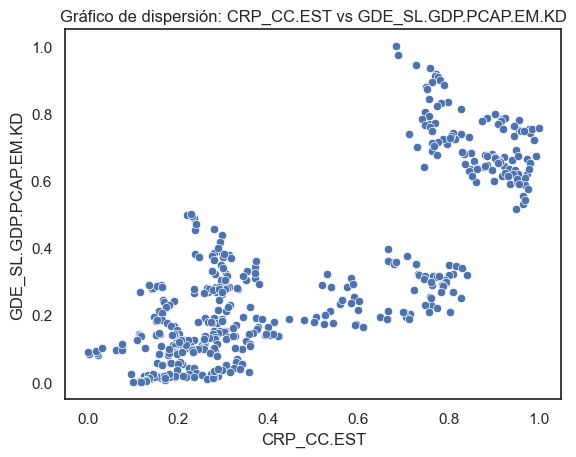

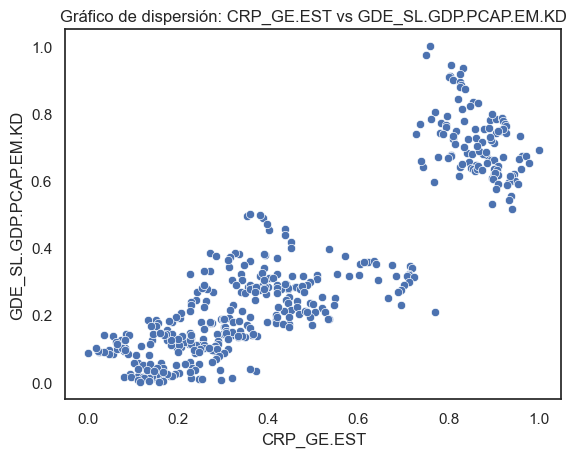

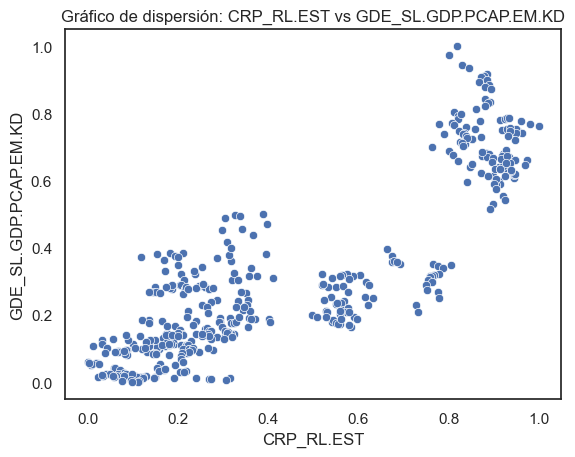

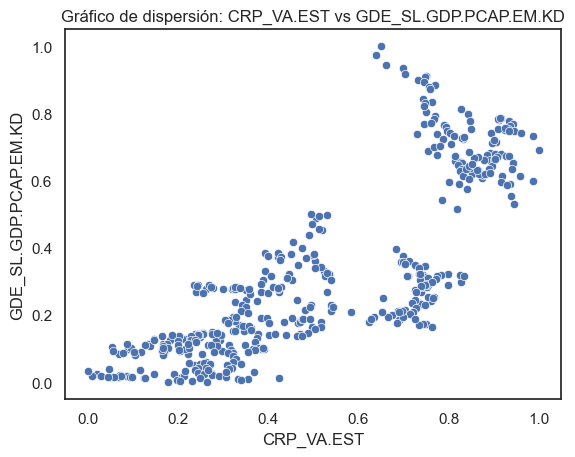

In [56]:
# Supongamos que 'reduced_df' contiene todas las variables
# y 'GDE_SL.GDP.PCAP.EM.KD' es tu variable dependiente
variables_independientes = ['CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']
variable_dependiente = 'GDE_SL.GDP.PCAP.EM.KD'

# Crear gráficos de dispersión para cada variable independiente con respecto a la variable dependiente
for variable in variables_independientes:
    sns.scatterplot(x=reduced_df[variable], y=reduced_df[variable_dependiente])
    plt.title(f'Gráfico de dispersión: {variable} vs {variable_dependiente}')
    plt.xlabel(variable)
    plt.ylabel(variable_dependiente)
    plt.show()


### 6.0.2. Análisis de interacción

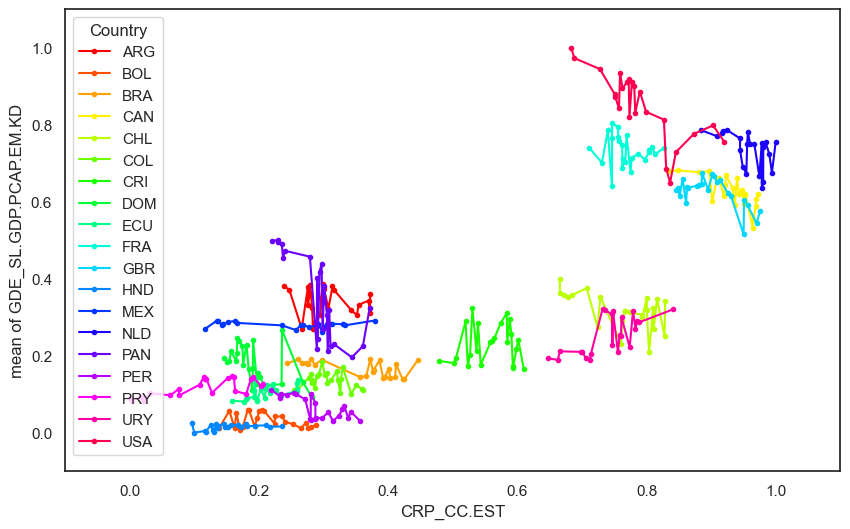

In [57]:
# Ejemplo de análisis de interacción posterior en Python
# Asumiendo que 'Country' es categórico y 'CRP_CC.EST' es continuo
fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(x=reduced_df['CRP_CC.EST'], trace=reduced_df['Country'], response=reduced_df['GDE_SL.GDP.PCAP.EM.KD'], ax=ax)
plt.show()

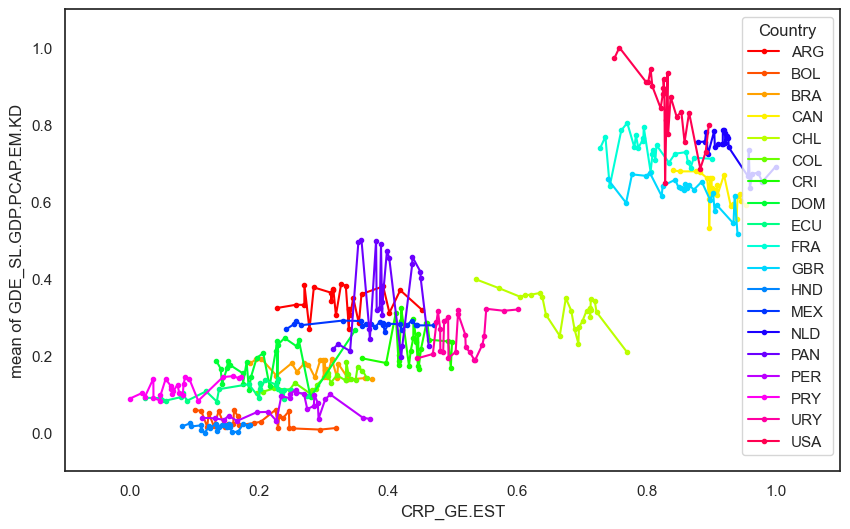

In [58]:
# Ejemplo de análisis de interacción posterior en Python
# Asumiendo que 'Country' es categórico y 'CRP_CC.EST' es continuo
fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(x=reduced_df['CRP_GE.EST'], trace=reduced_df['Country'], response=reduced_df['GDE_SL.GDP.PCAP.EM.KD'], ax=ax)
plt.show()

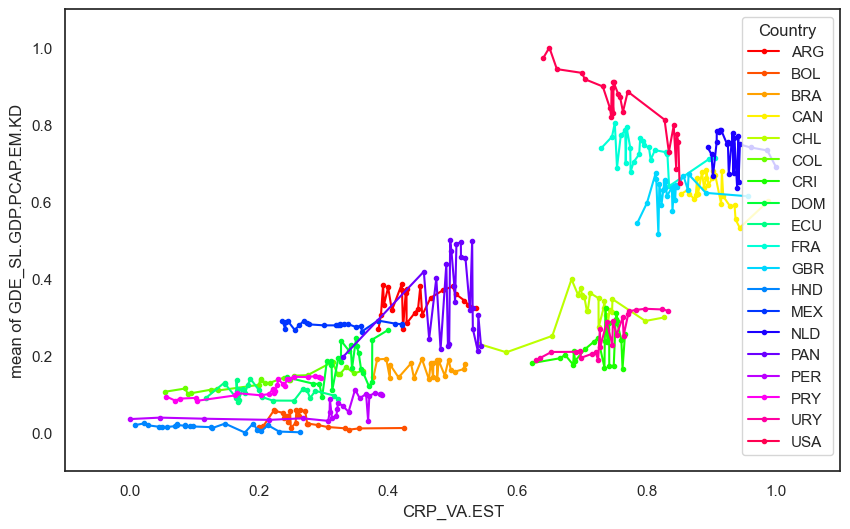

In [59]:
# Ejemplo de análisis de interacción posterior en Python
# Asumiendo que 'Country' es categórico y 'CRP_CC.EST' es continuo
fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(x=reduced_df['CRP_VA.EST'], trace=reduced_df['Country'], response=reduced_df['GDE_SL.GDP.PCAP.EM.KD'], ax=ax)
plt.show()

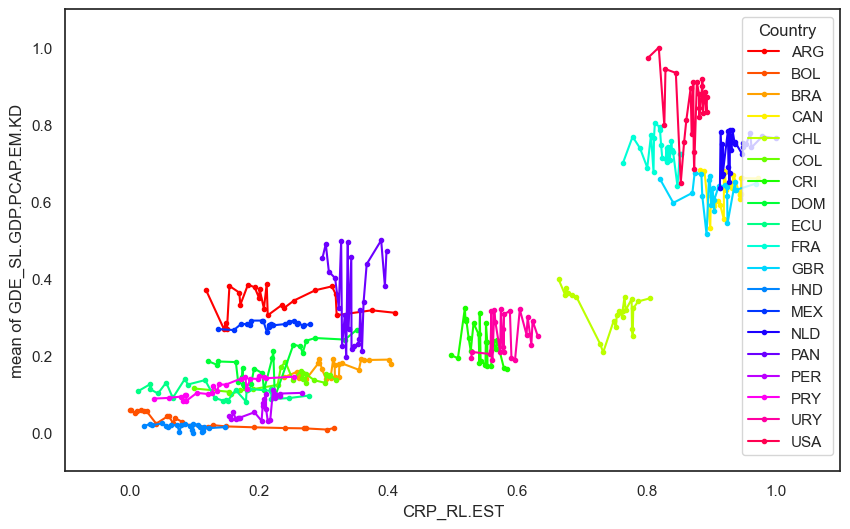

In [63]:
# Ejemplo de análisis de interacción posterior en Python
# Asumiendo que 'Country' es categórico y 'CRP_CC.EST' es continuo
fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(x=reduced_df['CRP_RL.EST'], trace=reduced_df['Country'], response=reduced_df['GDE_SL.GDP.PCAP.EM.KD'], ax=ax)
plt.show()

### 6.1. Matriz de correlación

In [64]:
corrm_concatenado

,Subconjunto,Variable,CRP_CC.EST,CRP_GE.EST,CRP_PV.EST,CRP_RL.EST,CRP_RQ.EST,CRP_VA.EST
0,Completo,GDE_SL.GDP.PCAP.EM.KD,0.801931,0.895211,NaN,0.86922,0.798729,0.812347
1,Colombia,GDE_SL.GDP.PCAP.EM.KD,NaN,NaN,0.861565,NaN,0.760178,0.924564


### 6.2. Comprobación de normalidad

In [65]:
norm_concatenado

,Subconjunto,Variable,Estadístico,Valor Crítico,Conclusión
0,Completo,CRP_CC.EST,22.313670,0.780,No Normal
1,Completo,CRP_GE.EST,15.094401,0.780,No Normal
2,Completo,CRP_PV.EST,1.579737,0.780,No Normal
3,Completo,CRP_RL.EST,20.925600,0.780,No Normal
4,Completo,CRP_RQ.EST,5.742889,0.780,No Normal
5,Completo,CRP_VA.EST,10.594579,0.780,No Normal
6,Completo,GDE_SL.GDP.PCAP.EM.KD,18.257534,0.780,No Normal
7,Colombia,CRP_CC.EST,0.218619,0.699,Normal
8,Colombia,CRP_GE.EST,0.570581,0.699,Normal
9,Colombia,CRP_PV.EST,0.377011,0.699,Normal


### 6.3. Análisis de correlación

In [66]:
resc_concatenado

,Subconjunto,Tipo de análisis,Variable,Correlación,Valor p
0,Completo,Pearson,CRP_CC.EST,0.764758,4.535905e-85
1,Completo,Pearson,CRP_GE.EST,0.867066,1.027764e-133
2,Completo,Pearson,CRP_PV.EST,0.698769,2.831368e-65
3,Completo,Pearson,CRP_RL.EST,0.839767,1.893396e-117
4,Completo,Pearson,CRP_RL.EST,0.567194,4.765683e-03
5,Completo,Pearson,CRP_RQ.EST,0.770354,4.769205e-87
6,Completo,Pearson,CRP_VA.EST,0.847371,1.176013e-121
9,Colombia,Spearman,CRP_CC.EST,-0.143521,5.135536e-01
10,Colombia,Spearman,CRP_GE.EST,0.744363,4.644915e-05
11,Colombia,Spearman,CRP_PV.EST,0.861565,1.290744e-07


### 6.4. Modelos de regresión

In [67]:
modelos_df
ruta_modelos_df = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Procesamiento\graficas_sl\matriz_modelos_df.csv'

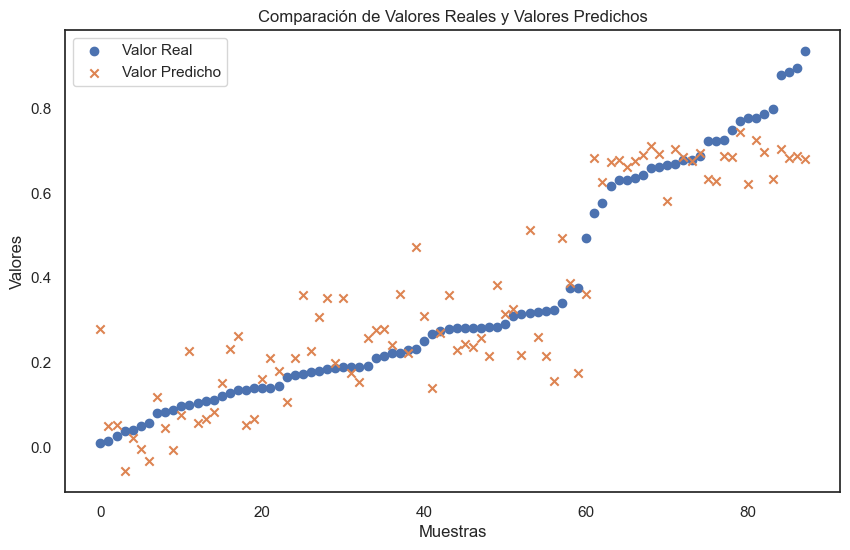

In [68]:
##visualizar modelo2 _sp
# Crear un DataFrame con los valores originales y predichos
comparison_df_sp = pd.DataFrame({'Valor Real': y_test_sp, 'Valor Predicho': y_pred_test_lr_sp})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df_sp = comparison_df_sp.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_sp)), comparison_df_sp['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df_sp)), comparison_df_sp['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

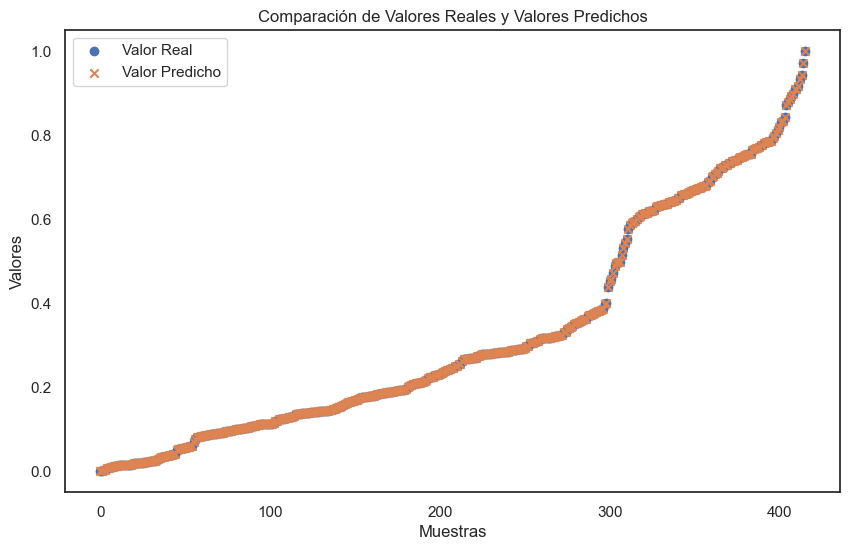

In [69]:
##visualizar modelo2 _cp
# Crear un DataFrame con los valores originales y predichos
comparison_df_cp = pd.DataFrame({'Valor Real': y_test_cp, 'Valor Predicho': y_pred_test_lr_cp})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df_cp = comparison_df_cp.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_cp)), comparison_df_cp['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df_cp)), comparison_df_cp['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

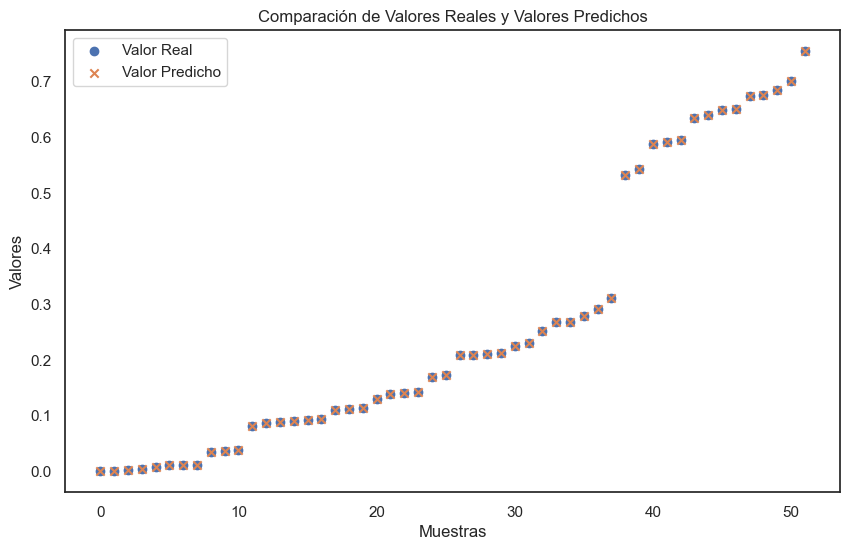

In [70]:
##visualizar modelo2 _cp_pred
# Crear un DataFrame con los valores originales y predichos
comparison_df_cp_pred = pd.DataFrame({'Valor Real': y_test_cp_pred, 'Valor Predicho': y_pred_test_lr_cp_pred})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df_cp_pred = comparison_df_cp_pred.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_cp_pred)), comparison_df_cp_pred['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df_cp_pred)), comparison_df_cp_pred['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

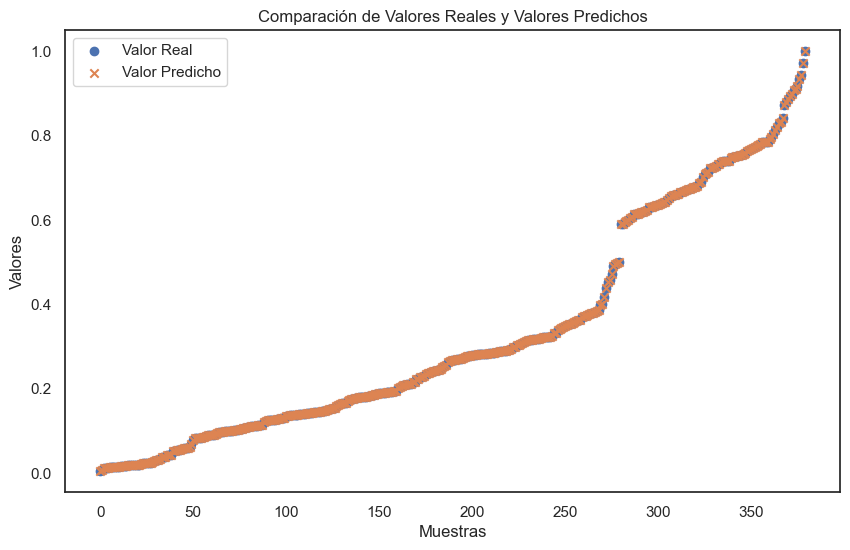

In [71]:
##visualizar modelo2 _cp_test
# Crear un DataFrame con los valores originales y predichos
comparison_df_cp_test = pd.DataFrame({'Valor Real':y_cp_test, 'Valor Predicho':  y_pred_cp_test})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df_cp_test = comparison_df_cp_test.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_cp_test)), comparison_df_cp_test['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df_cp_test)), comparison_df_cp_test['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

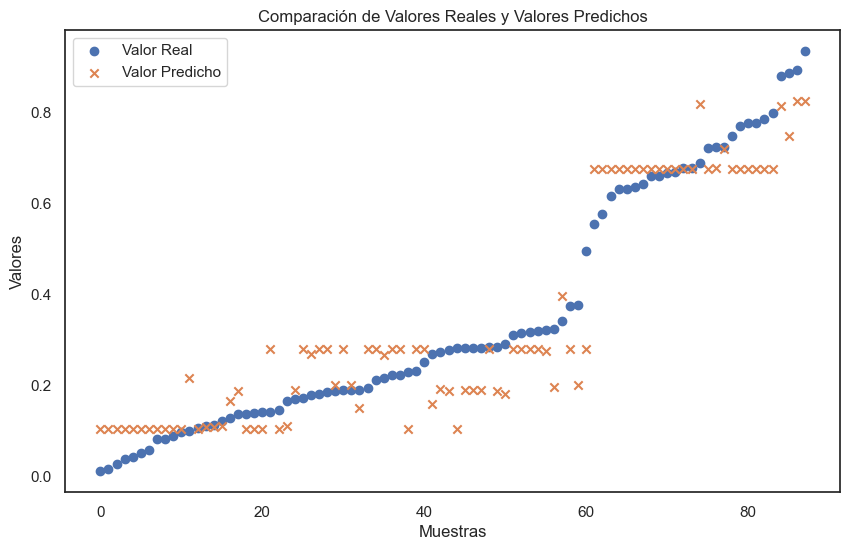

In [72]:
##visualizar modelo2 _rf_sp
# Crear un DataFrame con los valores originales y predichos
comparison_df_rf_sp = pd.DataFrame({'Valor Real':y_test_sp, 'Valor Predicho':  y_pred_test_rf_sp})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df_rf_sp = comparison_df_rf_sp.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_rf_sp)), comparison_df_rf_sp['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df_rf_sp)), comparison_df_rf_sp['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

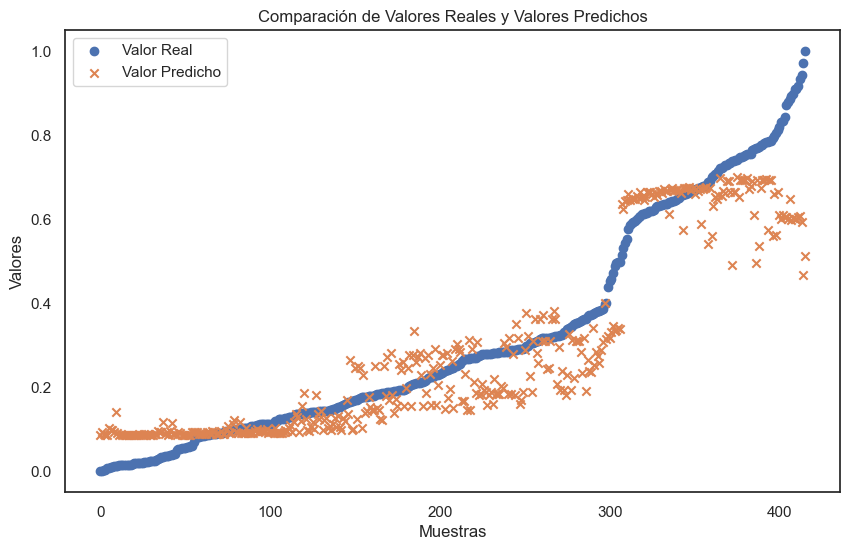

In [73]:
##visualizar modelo2 _rf_cp
# Crear un DataFrame con los valores originales y predichos
comparison_df_rf_cp = pd.DataFrame({'Valor Real':y_test_cp, 'Valor Predicho':  y_pred_test_rf_cp})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df_rf_cp = comparison_df_rf_cp.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_rf_cp)), comparison_df_rf_cp['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df_rf_cp)), comparison_df_rf_cp['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

## 6.5. Análisis de componentes principales

El hecho de que con 2 o 3 componentes principales se explique más del 95% de la varianza sugiere que estos componentes capturan la mayoría de la información de las variables de corrupción. El gráfico de varianza explicada acumulativa es útil para determinar cuántos componentes son necesarios para conservar una cantidad significativa de varianza.

El hecho de observar dos clusters distintos en el gráfico de resultados del PCA sugiere que estos clusters se deban a patrones o estructuras que los componentes principales han identificado. Podrían representar grupos o tendencias específicas.

Los pesos de los componentes principales indican la contribución de cada variable original a los componentes principales. En tu caso, el primer componente principal (PC1) tiene pesos relativamente altos para todas las variables, indicando que está capturando información general de todas ellas. Por otro lado, el segundo componente principal (PC2) tiene un peso significativamente alto para la variable 'CRP_GE.EST' y un peso negativo para 'CRP_VA.EST', lo que sugiere que PC2 podría estar relacionado con variaciones específicas en estas dos variables.

Los scores de los componentes principales representan las proyecciones de los datos originales en el espacio de los componentes principales. Los valores más altos o más bajos en los scores indican la posición relativa de cada observación en el espacio de los componentes principales:

**Componente Principal 1 (PC1):** Este componente parece capturar una tendencia general o patrón común en todas las variables.

**Componente Principal 2 (PC2)**: Este componente parece capturar variaciones específicas relacionadas con 'CRP_GE.EST' y 'CRP_VA.EST'.

In [74]:
# Imprime los pesos de los componentes principales
print("Pesos de Componentes Principales:")
pd.DataFrame(component_weights, columns=X.columns)

Pesos de Componentes Principales:


,CRP_CC.EST,CRP_GE.EST,CRP_RL.EST,CRP_VA.EST
0,0.507778,0.486936,0.544691,0.456472
1,0.041110,0.565812,0.136451,-0.812126


In [75]:
# Imprime los scores de los componentes principales
print("\nScores de Componentes Principales:")
pd.DataFrame(component_scores, columns=[f'Componente Principal {i + 1}' for i in range(n_components)])


Scores de Componentes Principales:


,Componente Principal 1,Componente Principal 2
0,-0.315061,-0.183395
1,-0.264755,-0.147570
2,-0.228970,-0.115808
3,-0.176118,-0.069428
4,-0.194705,-0.049887
...,...,...
432,0.766127,0.017236
433,0.797246,0.029729
434,0.776373,0.059104
435,0.770305,0.044609


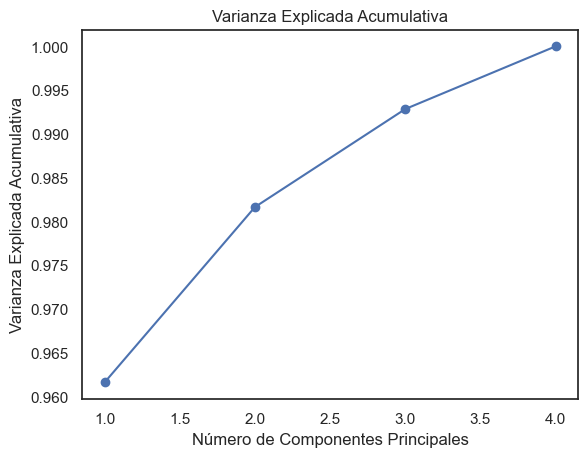

In [76]:
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Varianza Explicada Acumulativa')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulativa')
plt.show()

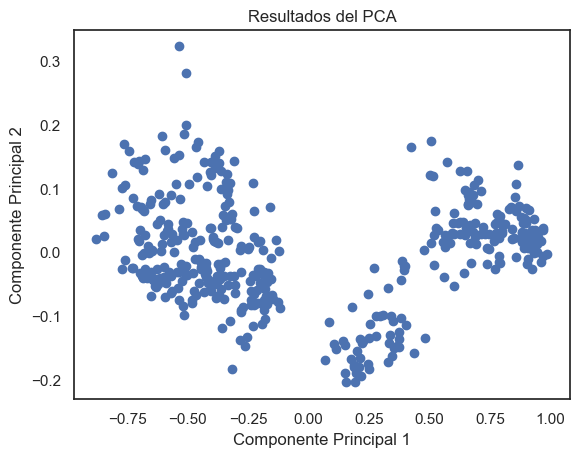

In [77]:
# Visualiza los resultados
plt.scatter(pca_df['Componente Principal 1'], pca_df['Componente Principal 2'])
plt.title('Resultados del PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

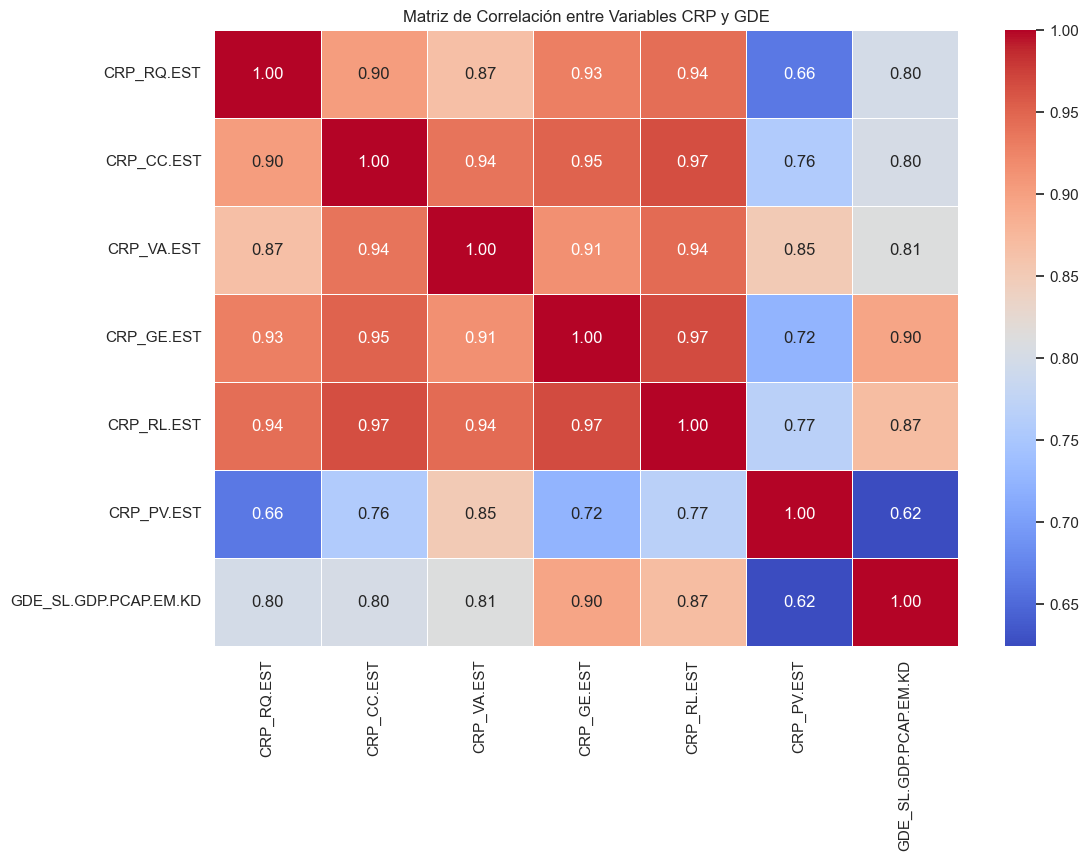

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook

# Cargar el DataFrame desde el archivo Excel
archivo_excel = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\structured_data\reduced_df_normalized.xlsx'
df = pd.read_excel(archivo_excel)

# Seleccionar las columnas que comienzan con "CRP" y "GDE"
columnas_crp = [col for col in df.columns if col.startswith('CRP')]
columnas_gde = [col for col in df.columns if col.startswith('GDE')]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_corr = df[columnas_crp + columnas_gde]

# Calcular la matriz de correlación
matriz_correlacion = df_corr.corr()

# Configurar el estilo del gráfico
sns.set(style='white')

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Mostrar el gráfico
plt.title('Matriz de Correlación entre Variables CRP y GDE')

# Guardar el gráfico en la ruta especificada
ruta_grafica = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Procesamiento\graficas_sl\correlacion.png'
plt.savefig(ruta_grafica)

# Mostrar la gráfica
plt.show()


In [79]:
import pandas as pd

# Cargar el DataFrame desde el archivo Excel
archivo_excel = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\structured_data\reduced_df_normalized.xlsx'
df = pd.read_excel(archivo_excel)

# Seleccionar las columnas que comienzan con "CRP" y "GDE"
columnas_crp = [col for col in df.columns if col.startswith('CRP')]
columnas_gde = [col for col in df.columns if col.startswith('GDE')]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_corr = df[columnas_crp + columnas_gde]

# Calcular la matriz de correlación
matriz_correlacion = df_corr.corr()

# Guardar la matriz de correlación en la ruta especificada
ruta_matriz_correlacion = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Procesamiento\graficas_sl\matriz_correlacion.csv'
matriz_correlacion.to_csv(ruta_matriz_correlacion, index=True)

# Mostrar la matriz de correlación
print(matriz_correlacion)


                       CRP_RQ.EST  CRP_CC.EST  CRP_VA.EST  CRP_GE.EST  \
CRP_RQ.EST               1.000000    0.903097    0.865787    0.929528   
CRP_CC.EST               0.903097    1.000000    0.937132    0.950565   
CRP_VA.EST               0.865787    0.937132    1.000000    0.913560   
CRP_GE.EST               0.929528    0.950565    0.913560    1.000000   
CRP_RL.EST               0.942162    0.965461    0.944671    0.966706   
CRP_PV.EST               0.663199    0.757157    0.850512    0.724064   
GDE_SL.GDP.PCAP.EM.KD    0.798729    0.801931    0.812347    0.895211   

                       CRP_RL.EST  CRP_PV.EST  GDE_SL.GDP.PCAP.EM.KD  
CRP_RQ.EST               0.942162    0.663199               0.798729  
CRP_CC.EST               0.965461    0.757157               0.801931  
CRP_VA.EST               0.944671    0.850512               0.812347  
CRP_GE.EST               0.966706    0.724064               0.895211  
CRP_RL.EST               1.000000    0.767194               

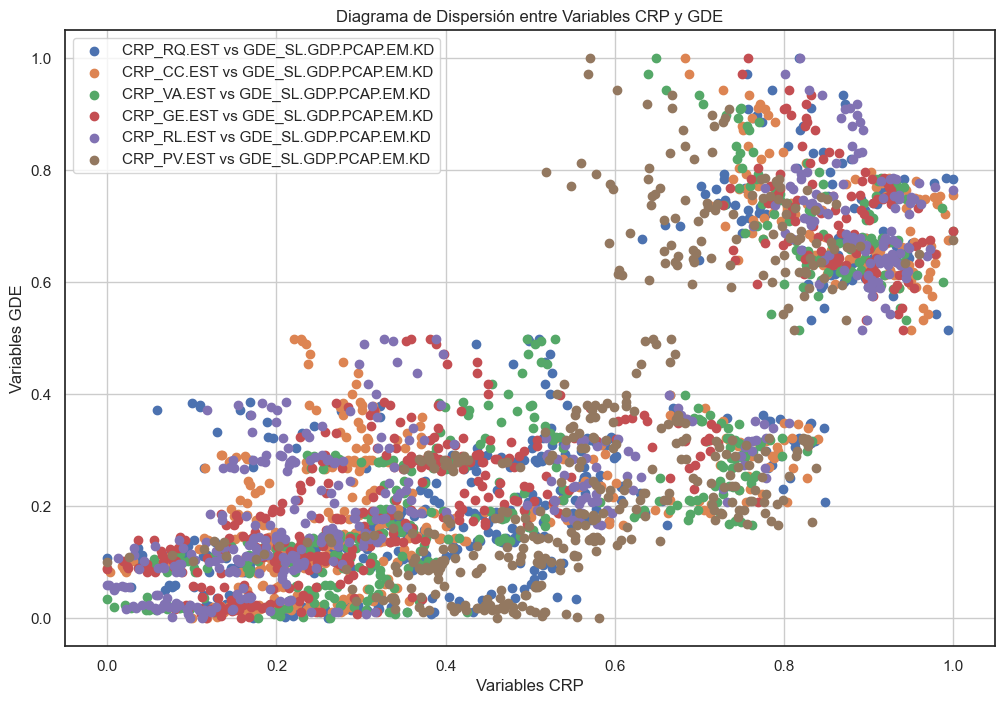

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el DataFrame desde el archivo Excel
archivo_excel = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\structured_data\reduced_df_normalized.xlsx'
df = pd.read_excel(archivo_excel)

# Seleccionar las columnas que comienzan con "CRP" y "GDE"
columnas_crp = [col for col in df.columns if col.startswith('CRP')]
columnas_gde = [col for col in df.columns if col.startswith('GDE')]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_dispersion = df[columnas_crp + columnas_gde]

# Crear un diagrama de dispersión
plt.figure(figsize=(12, 8))

# Iterar sobre las columnas y generar un diagrama de dispersión para cada par
for col_crp in columnas_crp:
    for col_gde in columnas_gde:
        plt.scatter(df_dispersion[col_crp], df_dispersion[col_gde], label=f'{col_crp} vs {col_gde}')

# Configurar el estilo del gráfico
plt.title('Diagrama de Dispersión entre Variables CRP y GDE')
plt.xlabel('Variables CRP')
plt.ylabel('Variables GDE')
plt.legend()
plt.grid(True)
plt.savefig('C:/JHAA\CEPAL_3/WorldBank-Corruption-Insights/Procesamiento/graficas_sl/diagrama_dispersión1.png')
# Mostrar el gráfico
plt.show()


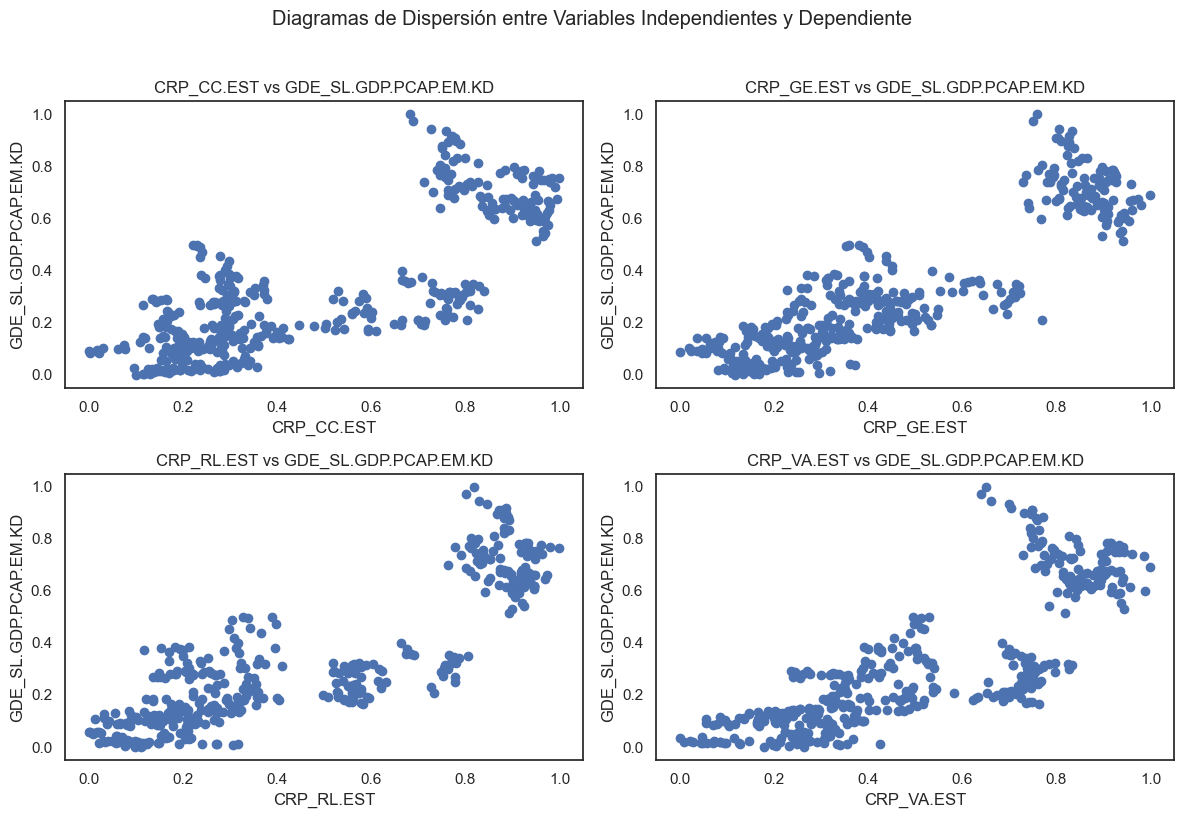

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el DataFrame desde el archivo Excel
archivo_excel = r'C:\JHAA\CEPAL_3\WorldBank-Corruption-Insights\Extraccion\structured_data\reduced_df_normalized.xlsx'
df = pd.read_excel(archivo_excel)

# Definir las variables independientes y la variable dependiente
variables_independientes = ['CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']
variable_dependiente = 'GDE_SL.GDP.PCAP.EM.KD'

# Crear subgráficos
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Diagramas de Dispersión entre Variables Independientes y Dependiente', y=1.02)

# Iterar sobre las variables independientes y generar un diagrama de dispersión para cada una
for i, variable_independiente in enumerate(variables_independientes):
    row = i // 2
    col = i % 2
    axs[row, col].scatter(df[variable_independiente], df[variable_dependiente])
    axs[row, col].set_title(f'{variable_independiente} vs {variable_dependiente}')
    axs[row, col].set_xlabel(variable_independiente)
    axs[row, col].set_ylabel(variable_dependiente)

# Ajustar el diseño y mostrar los gráficos
plt.savefig('C:/JHAA\CEPAL_3/WorldBank-Corruption-Insights/Procesamiento/graficas_sl/diagrama_dispersión.png')
plt.tight_layout()
plt.show()
